*ENUNCIADO*


Considere a tabela abaixo, com as falhas diárias numa linha de produção e respectivos valores associados a perdas

Modele a frequencia por uma Poisson e a severidade por uma Gamma. Na simulação, obtenha pelos menos 10.000 cenários

Calcular o VaR operacional para falhas de 1 dia com 95% e 99% de intervalo de confiança

Dados do problema:


In [220]:
import pandas
df = pandas.read_csv("Q2_falhas.tsv", sep="\t").fillna(0).set_index("dia")
df

,falhas,p1,p2,p3,p4,p5,p6
dia,,,,,,,
1,0,0.00,0.00,0.0,0.0,0.0,0.0
2,2,5509.07,10825.40,0.0,0.0,0.0,0.0
3,1,9884.46,0.00,0.0,0.0,0.0,0.0
4,0,0.00,0.00,0.0,0.0,0.0,0.0
5,0,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
86,1,11637.88,0.00,0.0,0.0,0.0,0.0
87,1,56998.21,0.00,0.0,0.0,0.0,0.0
88,2,117041.47,22054.76,0.0,0.0,0.0,0.0


Para simular a frequência e a severidade, precisamos extrair a média de falhas por dia e quantidade total de falhas:

In [221]:
qty = df["falhas"].sum()
qty

148

In [222]:
avg = qty / len(df)
round(avg, 2)

1.64

Primeiramente, vamos extrair 100000 números aleatórios de uma distribuição Poisson para simular a coluna de falhas:

In [223]:
import numpy
sample_size = 100000
falhas = numpy.random.poisson(avg, sample_size)
falhas_max = falhas.max()
falhas

array([3, 2, 1, ..., 1, 1, 1])

Agora, para modelar a severidade com a distribuição Gamma precisamos estimar os parâmetros Alfa e Beta. Mas antes precisamos das médias m1 e m2:

In [224]:
sev = df[["p1", "p2", "p3", "p4", "p5", "p6"]].to_numpy().flatten()
sev = sev[sev != 0]
sev2 = sev**2
m1 = sev.sum() / qty
m2 = sev2.sum() / qty
print("m1: " + str(round(m1, 2)) + " -- m2: " + str(round(m2, 2)))

m1: 50701.03 -- m2: 4442312627.75


Com isso, seguem Alfa e Beta:

In [225]:
alfa = m1**2 / (m2 - m1**2)
beta = (m2 - m1**2) / m1
print("alfa: " + str(round(alfa, 2)) + " -- beta: " + str(round(beta, 2)))

alfa: 1.37 -- beta: 36916.78


Assim, montamos os dados simulados:

In [226]:
sim = pandas.DataFrame(columns=numpy.arange(falhas_max + 1))
sim[0] = falhas

random_gnum = 1 / numpy.random.gamma(shape=alfa, scale=1 / beta, size=sample_size * falhas_max)
i = 0
somas = []
for row in numpy.split(random_gnum, sample_size):
    sim.loc[i, 1:falhas_max] = row
    sim.loc[i, sim.loc[i, 0] + 1:falhas_max] = 0
    somas.append(sim.loc[i, 1:falhas_max].sum())
    i += 1
sim["soma"] = somas
sim.rename({0: "falhas"}, axis=1, inplace=True)

sim

,falhas,1,2,3,4,5,6,7,8,9,10,11,soma
0,3,25973.111346,25108.533149,273001.899441,0,0,0,0,0,0,0,0,324083.543936
1,2,12859.968985,13732.275312,0,0,0,0,0,0,0,0,0,26592.244297
2,1,260228.746641,0,0,0,0,0,0,0,0,0,0,260228.746641
3,4,189201.686062,32414.518702,72130.616756,486343.43944,0,0,0,0,0,0,0,780090.260960
4,4,8631.05829,191558.890924,13606.865691,36997.601489,0,0,0,0,0,0,0,250794.416393
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
99996,3,120705.465258,60693.745538,47369.36272,0,0,0,0,0,0,0,0,228768.573516
99997,1,31230.184765,0,0,0,0,0,0,0,0,0,0,31230.184765
99998,1,28196.174755,0,0,0,0,0,0,0,0,0,0,28196.174755


<AxesSubplot:ylabel='Frequency'>

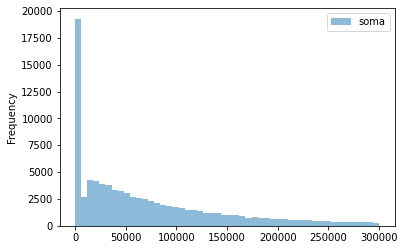

In [227]:
sim.loc[sim.soma < numpy.percentile(sim["soma"], 90)].plot.hist(column=["soma"], bins=50, alpha=0.5)


Para os IC 95% e 99%, temos os seguinte valores de VaR:

In [228]:
var95 = numpy.percentile(sim["soma"], 95)
var99 = numpy.percentile(sim["soma"], 99)
print("95% => " + str(round(var95, 2)) + " -- 99% => " + str(round(var99, 2)))

95% => 487718.47 -- 99% => 1360491.75
